In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [86]:
df_train = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
df_previous = pd.read_csv("/kaggle/input/home-credit-default-risk/previous_application.csv")
df_installments = pd.read_csv("/kaggle/input/home-credit-default-risk/installments_payments.csv")
df_credit = pd.read_csv("/kaggle/input/home-credit-default-risk/credit_card_balance.csv")
df_cash = pd.read_csv("/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv")
df_bureau = pd.read_csv("/kaggle/input/home-credit-default-risk/bureau.csv")
df_balance = pd.read_csv("/kaggle/input/home-credit-default-risk/bureau_balance.csv")

In [87]:
def memory_usage(df):
    print('Memory Usage Before :',round(df.memory_usage(index=True).sum()*10e-6,2))
    df = df.replace([np.inf, -np.inf], np.nan)
    for col in df.columns:
        if df[col].dtype == int:
            if df[col].dtype =='int64' and max(df[col])<127 and min(df[col])>-128:
                df[col]=df[col].astype('int8')
            elif df[col].dtype =='int64' and max(df[col])<32767 and min(df[col])>-32767 :
                df[col] = df[col].astype('int16')
            elif df[col].dtype =='int64' and max(df[col])<2147483648 and min(df[col])>-2147483648:
                df[col] = df[col].astype('int32')
        elif df[col].dtype == float :
            if df[col].dtype =='float64' and max(df[col])<6.55e+4 and min(df[col])>-6.55e+4 :
                df[col] = df[col].astype('float16')
            elif df[col].dtype =='float64' and max(df[col])<3.4+38 and min(df[col])>-3.4e+4:
                df[col] = df[col].astype('float32')
    print('Memory Usage After :',round(df.memory_usage(index=True).sum()*10e-6,2))
    print('-----------------------------------------------')
    return df

In [88]:
df_train = memory_usage(df_train)
df_previous = memory_usage(df_previous)
df_installments = memory_usage(df_installments)
df_credit = memory_usage(df_credit)
df_cash = memory_usage(df_cash)
df_bureau = memory_usage(df_bureau)
df_balance = memory_usage(df_balance)

Memory Usage Before : 3001.31
Memory Usage After : 1036.31
-----------------------------------------------
Memory Usage Before : 4943.83
Memory Usage After : 3908.3
-----------------------------------------------
Memory Usage Before : 8707.46
Memory Usage After : 4353.73
-----------------------------------------------
Memory Usage Before : 7066.18
Memory Usage After : 4723.59
-----------------------------------------------
Memory Usage Before : 6400.87
Memory Usage After : 2500.34
-----------------------------------------------
Memory Usage Before : 2334.34
Memory Usage After : 1596.28
-----------------------------------------------
Memory Usage Before : 6551.98
Memory Usage After : 3548.99
-----------------------------------------------


# Functions to analyse the data :

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [90]:
# Show missing values in dataframes (values counts, distribution, percentages) and their shapes

def show_missing_values(df,ax):
    df_numerical = df[df.select_dtypes(include='number').columns]
    count = pd.DataFrame(df_numerical.columns,columns=['FEATURE'])
    count['MISSING_VALUES_PCT'] = -1.0
    for col in df_numerical.columns:
        count.loc[count['FEATURE']==col, 'MISSING_VALUES_PCT'] = df_numerical[col].isnull().sum()/df_numerical[col].shape[0]     
    count = count.sort_values(by=['MISSING_VALUES_PCT'],ascending=False)
    count = count[count['MISSING_VALUES_PCT']>0.4]
    
    sns.barplot(x="MISSING_VALUES_PCT", y="FEATURE", data=count,
            label="Missing values", color="c",ax=ax[0])
    for container in ax[0].containers:
        ax[0].bar_label(container)
    
    return count
       

In [91]:
# Show distribution of the TARGET values
def show_distribution_target(df,ax):
    sns.histplot(df['TARGET'],ax=ax[1],stat='percent',bins=2,)
    ax[1].set_xticks([0,1])
    for container in ax[1].containers:
        ax[1].bar_label(container)

In [92]:
# Show correlation between features and TARGET (more than 0.04)

def correlation_target(df,ax):
    columns = df.select_dtypes(include='number').columns
    corr_temp = df[columns].corr()[['TARGET']]
    corr = corr_temp.sort_values(by=['TARGET'],ascending = False)
    corr = corr[corr['TARGET']>0.04]
    sns.heatmap(corr,annot=True,ax=ax[0])
    corr_negative = corr_temp.sort_values(by=['TARGET'],ascending = True)
    corr_negative = corr_negative[corr_negative['TARGET']<-0.04]
    sns.heatmap(corr_negative,annot=True,ax=ax[1])
    return corr_temp
    

In [93]:
# Show correlation between all features (see which ones are correlated)

def correlation(df,ax,n=30):
    
    columns = df.select_dtypes(include='number').columns
    corr = df[columns].corr()
    correlation = pd.DataFrame(columns=['COLUMN_1','COLUMN_2','CORRELATION'])
    correlation['CORRELATION']=corr['SK_ID_CURR'].values
    correlation['COLUMN_1']='SK_ID_CURR'
    correlation['COLUMN_2']=corr['SK_ID_CURR'].index
    columns.delete(0)
    df_append = pd.DataFrame(columns=['COLUMN_1','COLUMN_2','CORRELATION'])
    for col in df[columns].columns:
        corr_temp = corr[col]
        df_append['CORRELATION'] = corr_temp.values
        df_append['COLUMN_1'] = col
        df_append['COLUMN_2'] = corr_temp.index
        correlation = pd.concat([correlation,df_append])
    
    correlation = correlation.drop_duplicates(subset=['CORRELATION'])
    correlation['NAME'] = correlation['COLUMN_1']+ "  et   " + correlation['COLUMN_2']
    correlation_positive = correlation[(correlation['CORRELATION'] > 0.6) & (correlation['CORRELATION'] != 1)]
    correlation_negative = correlation[(correlation['CORRELATION'] < -0.4) & (correlation['CORRELATION'] != 1)]
    correlation_positive = correlation_positive.sort_values(by=['CORRELATION'],ascending = False)
    correlation_negative = correlation_negative.sort_values(by=['CORRELATION'],ascending = True)
    correlation_positive = correlation_positive.head(n)
    correlation_negative = correlation_negative.head(n)
    if not correlation_positive.empty:
        sns.barplot(x='CORRELATION',y='NAME',data=correlation_positive,ax=ax[0])
        for container in ax[0].containers:
            ax[0].bar_label(container)
    if not correlation_negative.empty:
        correlation_negative['CORRELATION']= correlation_negative['CORRELATION'].abs()
        sns.barplot(x='CORRELATION',y='NAME',data=correlation_negative,ax=ax[1])
        for container in ax[1].containers:
            ax[1].bar_label(container)
    return correlation_positive
    
        

In [94]:
def show_stats(df,target=False):
    f,ax = plt.subplots(1,2,figsize=(15,15),layout="constrained")
    f2,ax2 = plt.subplots(1,2,figsize=(15,15),layout="constrained")
    f3,ax3 = plt.subplots(1,2,figsize=(15,15),layout="constrained")
    f4,ax4 = plt.subplots(1,2,figsize=(15,15),layout="constrained")
    show_missing_values(df,ax)
    show_distribution_target(df,ax)
    correlation_target(df,ax2)
    correlation(df,ax3)
    show_distribution_numerical(df,ax4)
    plt.tight_layout()
    plt.show()
    

In [95]:
# Show distribution of categorical and numerical features
def show_distribution_numerical(df, ax):
    total_columns = df.shape[1]
    num_cols = df.select_dtypes(include='number').shape[1]
    cat_cols = df.select_dtypes(exclude='number').shape[1]

    data = pd.DataFrame({
        'Type': ['Numerical', 'Categorical'],
        'Count': [num_cols, cat_cols],
        'Percentage': [num_cols / total_columns * 100, cat_cols / total_columns * 100]
    })

    sns.barplot(data=data, x='Type', y='Percentage', hue='Count', ax=ax[0])

    for container in ax[0].containers:
        ax[0].bar_label(container)


In [96]:
# Repartition of categorical and numerical features
# Distribution of all numerical features
# Analysis of continuous variables
# Analysis of categorical variables

# Exploratory data analysis for each dataset :
## Dataframes shapes :

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_36/1363596315.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


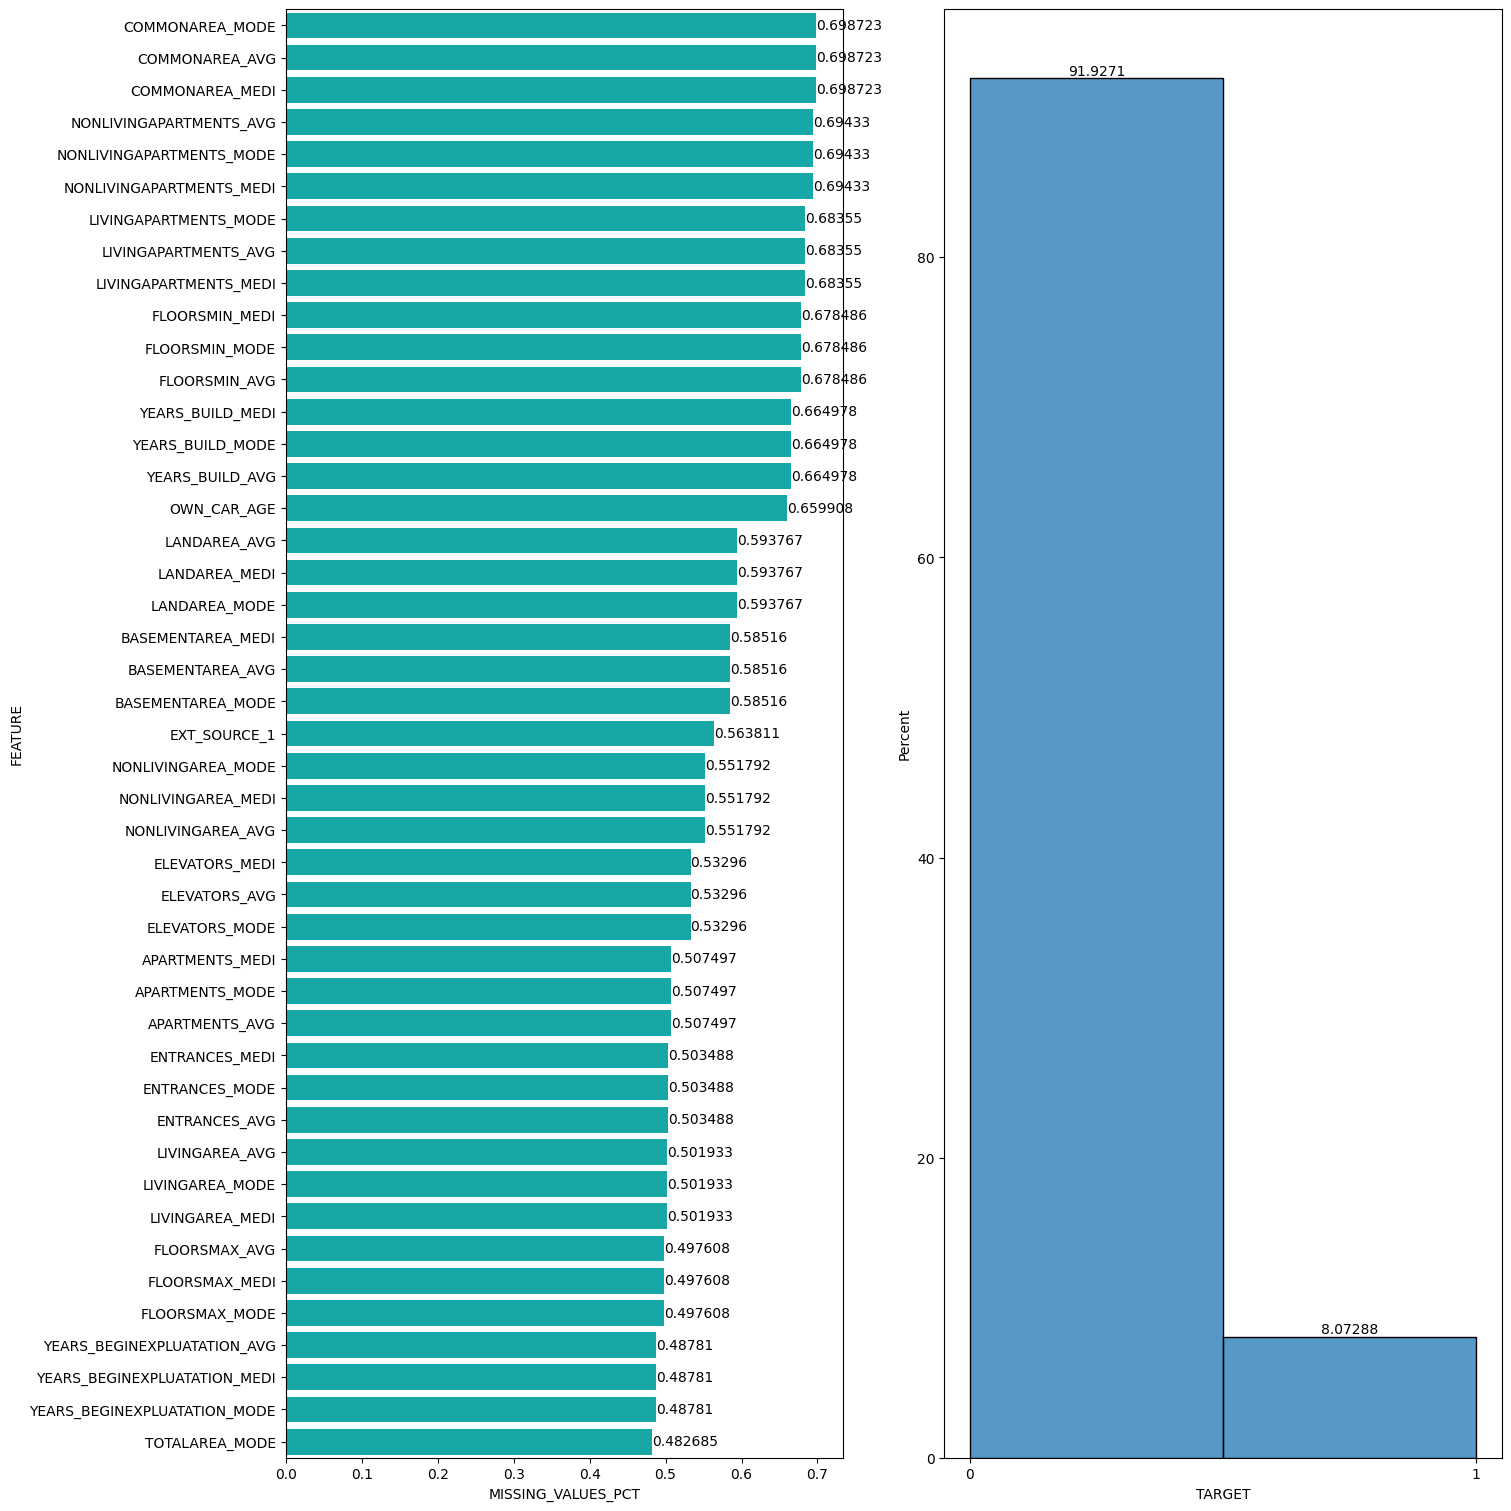

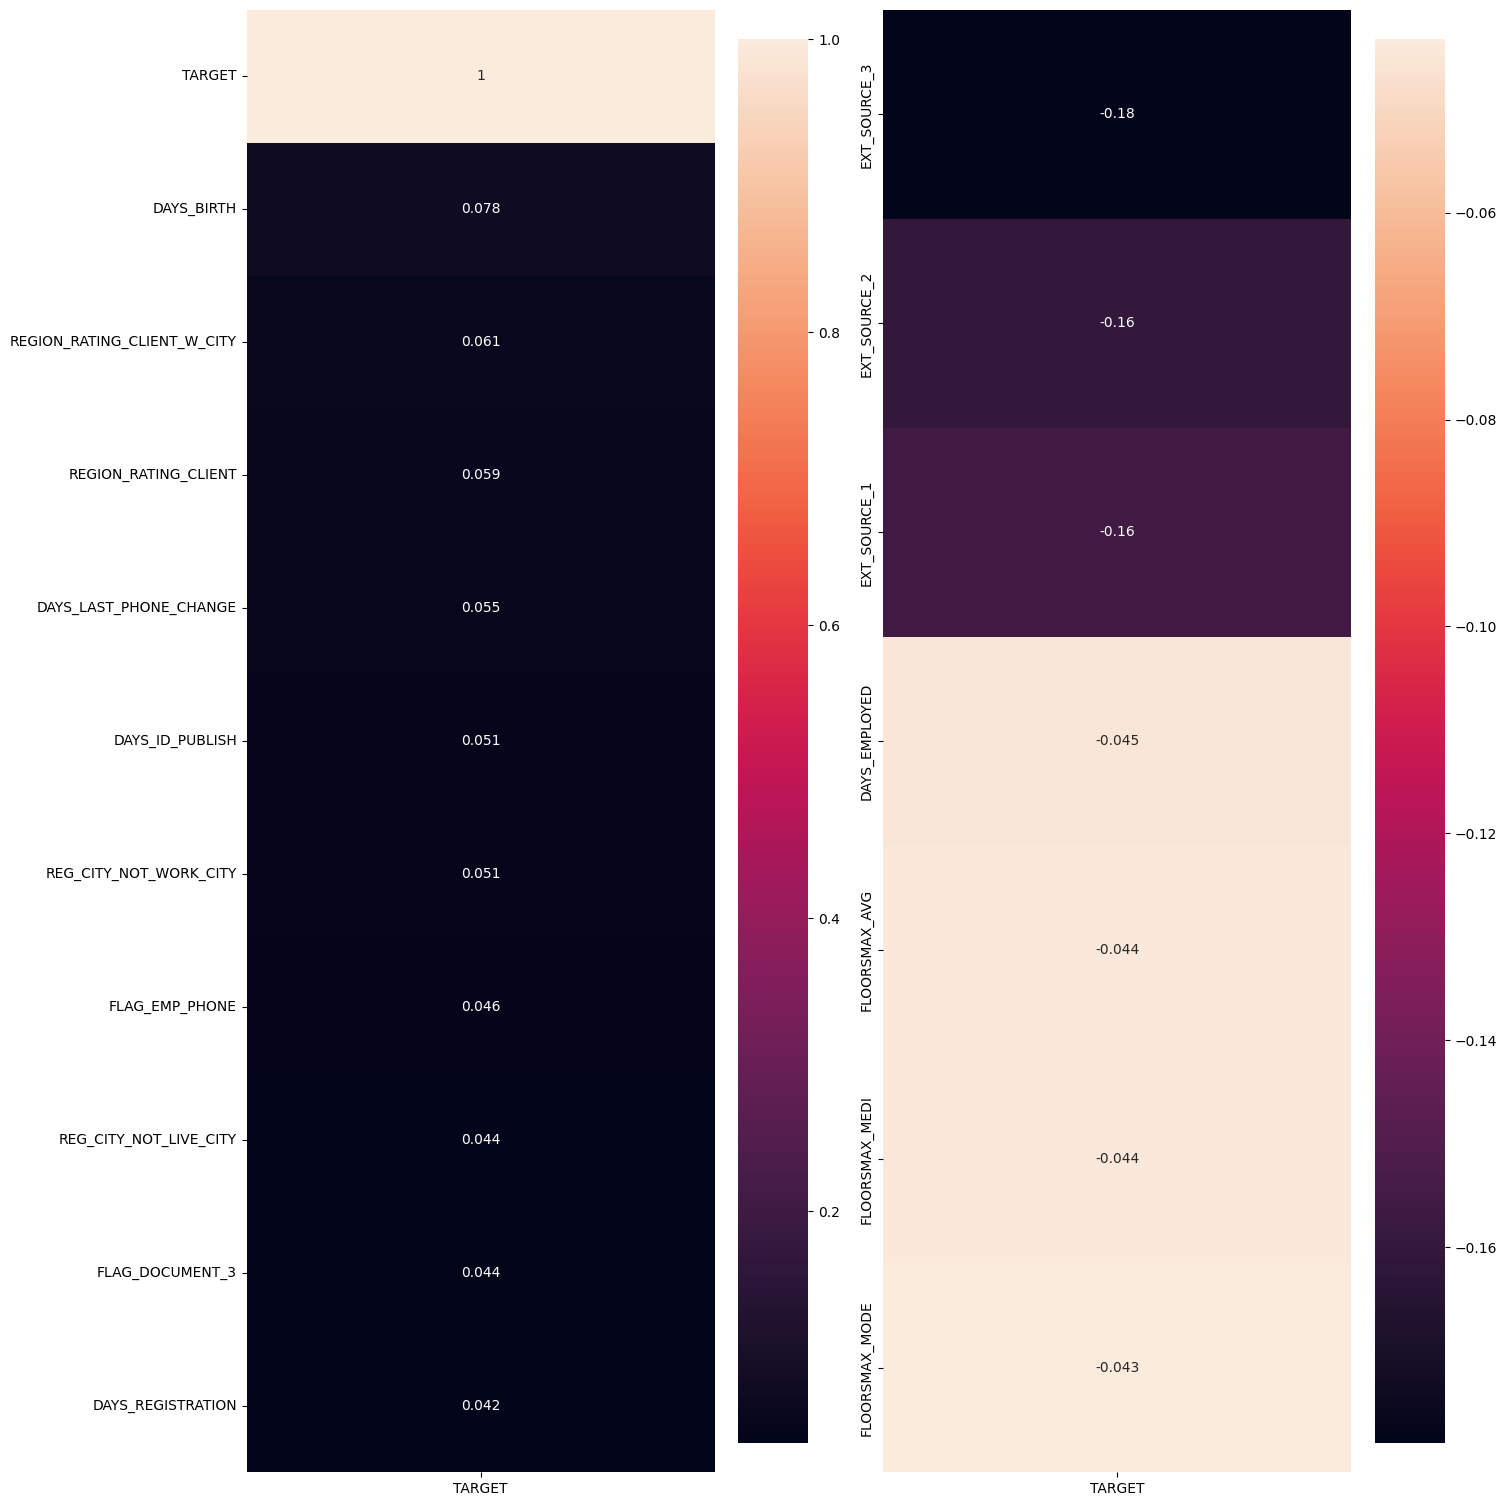

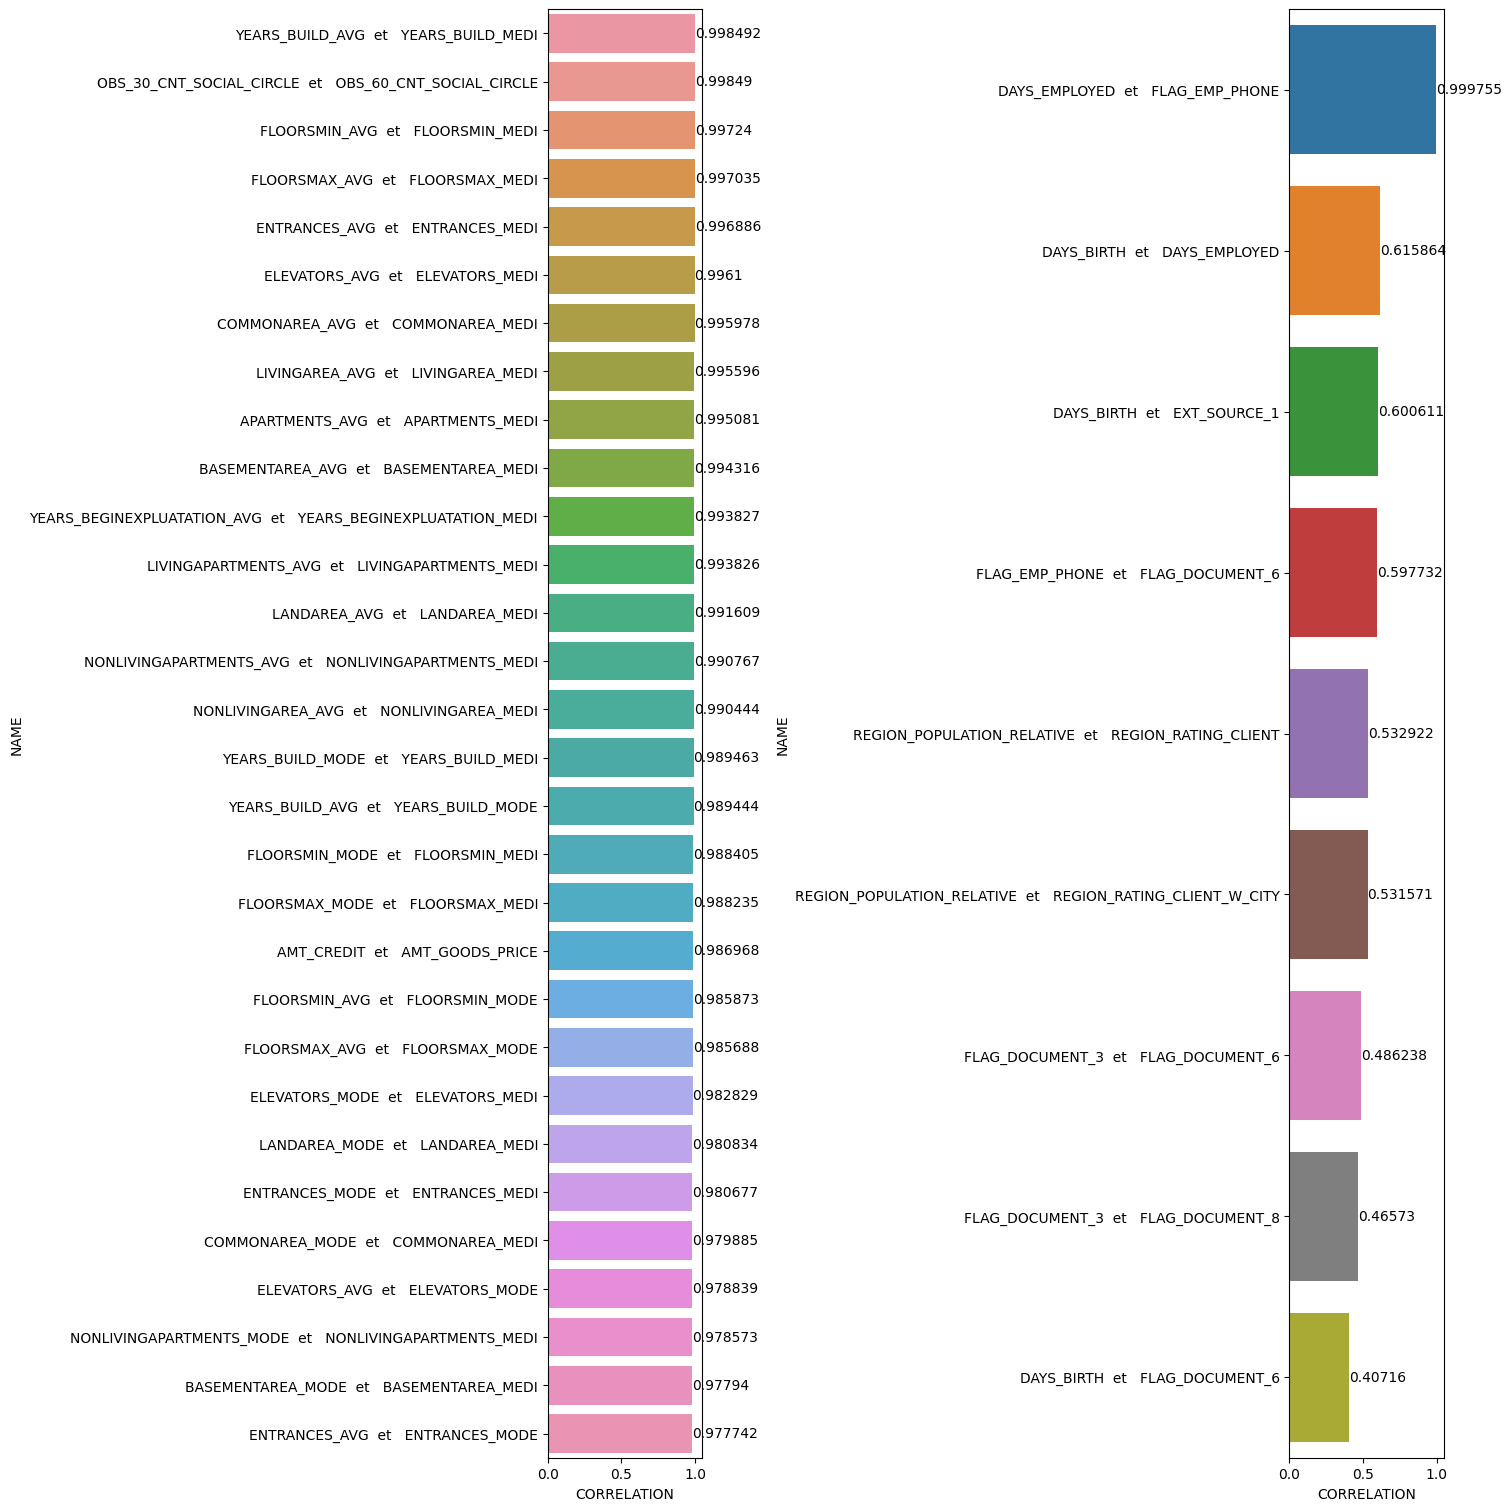

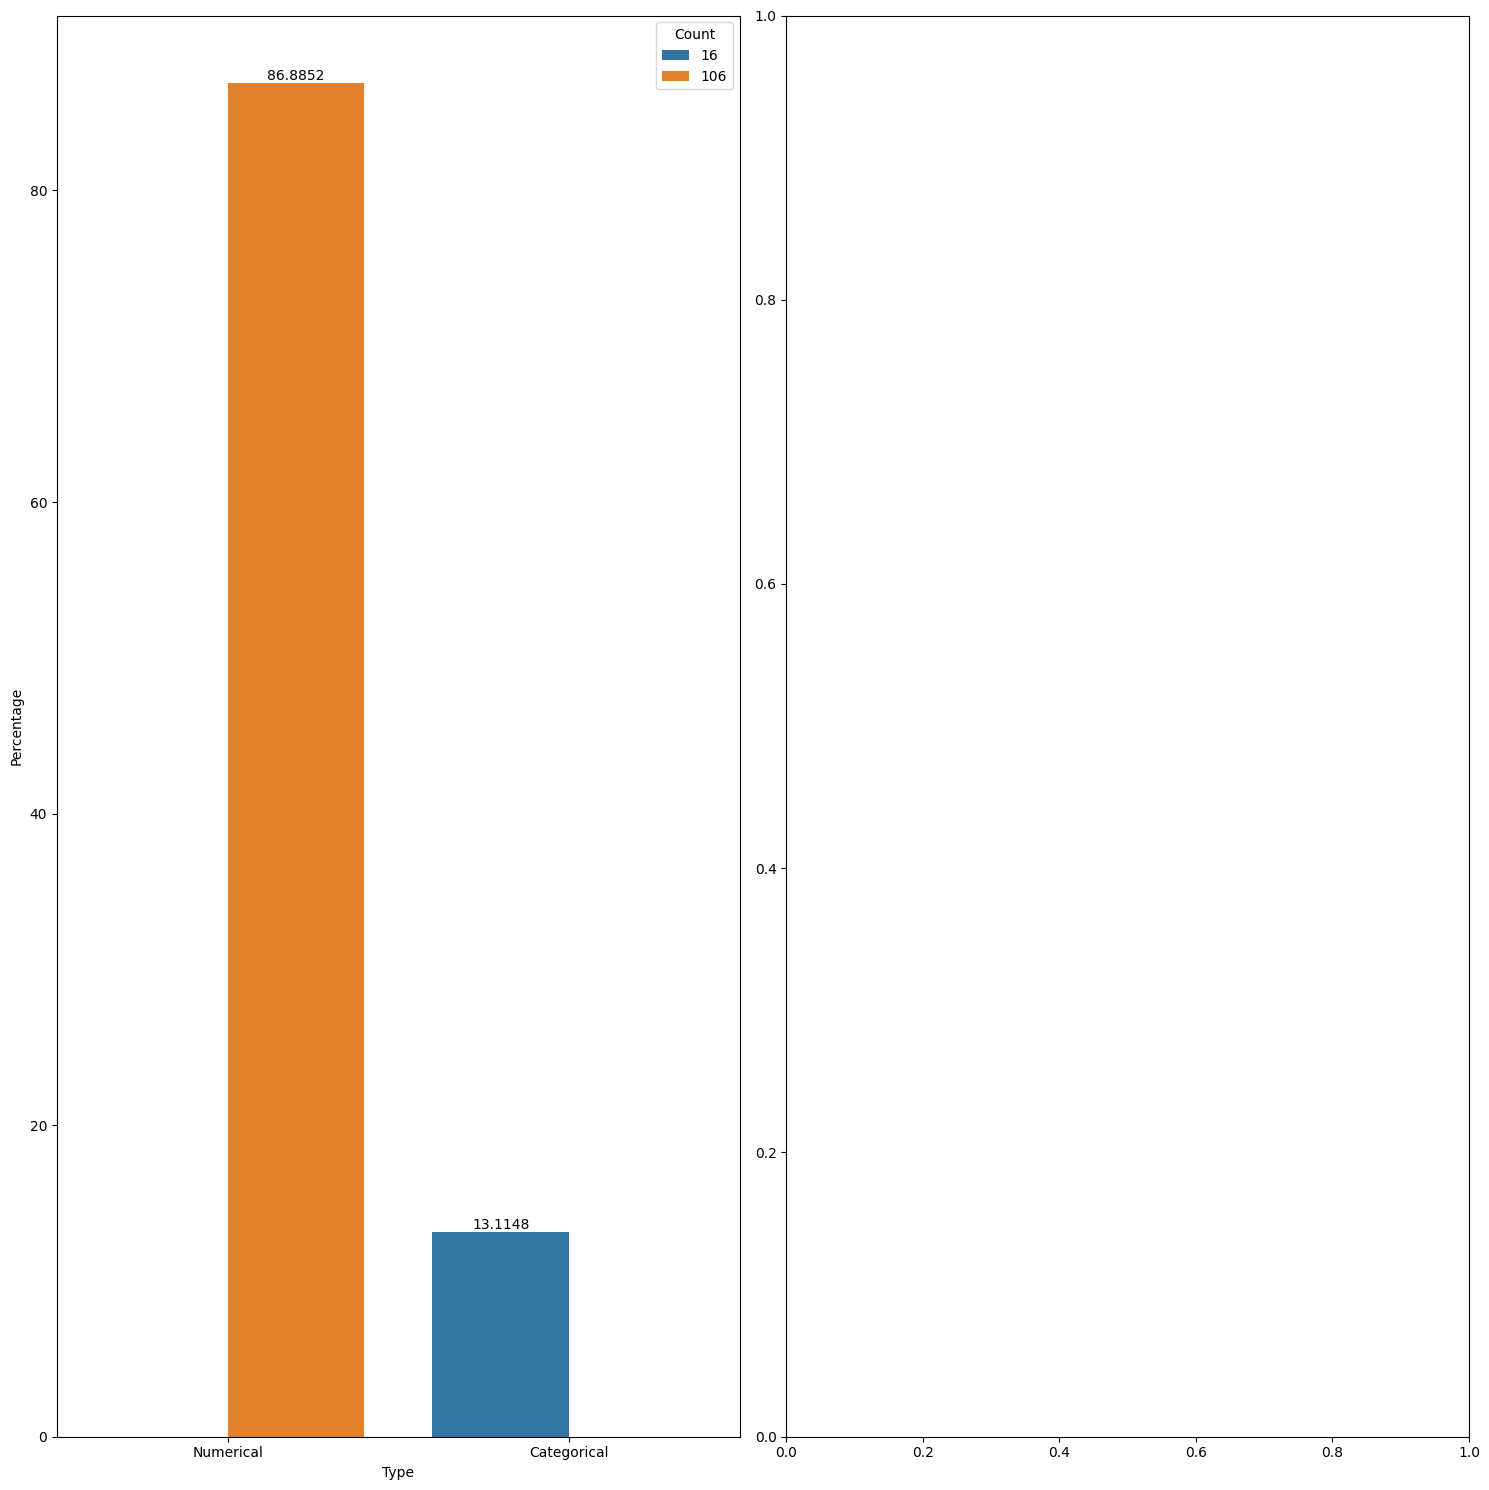

In [97]:
show_stats(df_train)